In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, brier_score_loss
from sklearn.metrics import classification_report, f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV

from sklearn.ensemble import RandomForestRegressor

### Training data summery

In [3]:
df = pd.read_csv('train_V2.csv')

In [4]:
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00,0,0,0,60,...,0,0.0000,0,0.00,0,0,244.80,1,1466,0.4444
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.47,0,0,0,57,...,0,0.0045,0,11.04,0,0,1434.00,5,0,0.6400
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00,0,0,0,47,...,0,0.0000,0,0.00,0,0,161.80,2,0,0.7755
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90,0,0,0,75,...,0,0.0000,0,0.00,0,0,202.70,3,0,0.1667
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00,0,0,0,45,...,0,0.0000,0,0.00,0,0,49.75,2,0,0.1875


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4446966 entries, 0 to 4446965
Data columns (total 29 columns):
 #   Column           Dtype  
---  ------           -----  
 0   Id               object 
 1   groupId          object 
 2   matchId          object 
 3   assists          int64  
 4   boosts           int64  
 5   damageDealt      float64
 6   DBNOs            int64  
 7   headshotKills    int64  
 8   heals            int64  
 9   killPlace        int64  
 10  killPoints       int64  
 11  kills            int64  
 12  killStreaks      int64  
 13  longestKill      float64
 14  matchDuration    int64  
 15  matchType        object 
 16  maxPlace         int64  
 17  numGroups        int64  
 18  rankPoints       int64  
 19  revives          int64  
 20  rideDistance     float64
 21  roadKills        int64  
 22  swimDistance     float64
 23  teamKills        int64  
 24  vehicleDestroys  int64  
 25  walkDistance     float64
 26  weaponsAcquired  int64  
 27  winPoints   

In [6]:
df.shape

(4446966, 29)

### Check Target Variable distribution

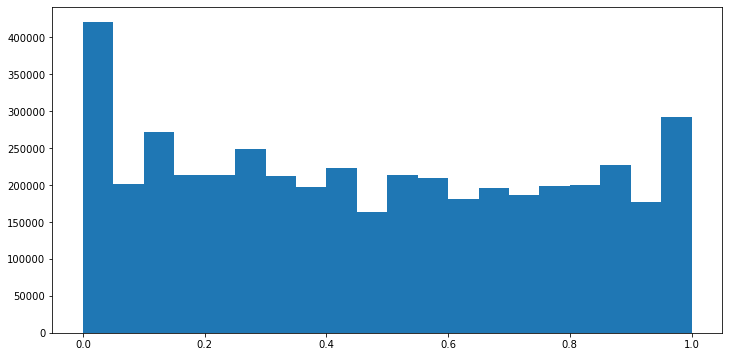

In [7]:
plt.figure(figsize = (12 , 6))
plt.hist(df['winPlacePerc'], bins = 20)
plt.show()

### Null Value Remove

In [8]:
df.isnull().sum().to_frame()

,0
Id,0
groupId,0
matchId,0
assists,0
boosts,0
damageDealt,0
DBNOs,0
headshotKills,0
heals,0
killPlace,0


In [9]:
df = df.dropna()

#### Drop apparent useless variable

In [10]:
df = df.drop(['Id', 'groupId', 'matchId'], axis = 1)

### Highly-related features removed

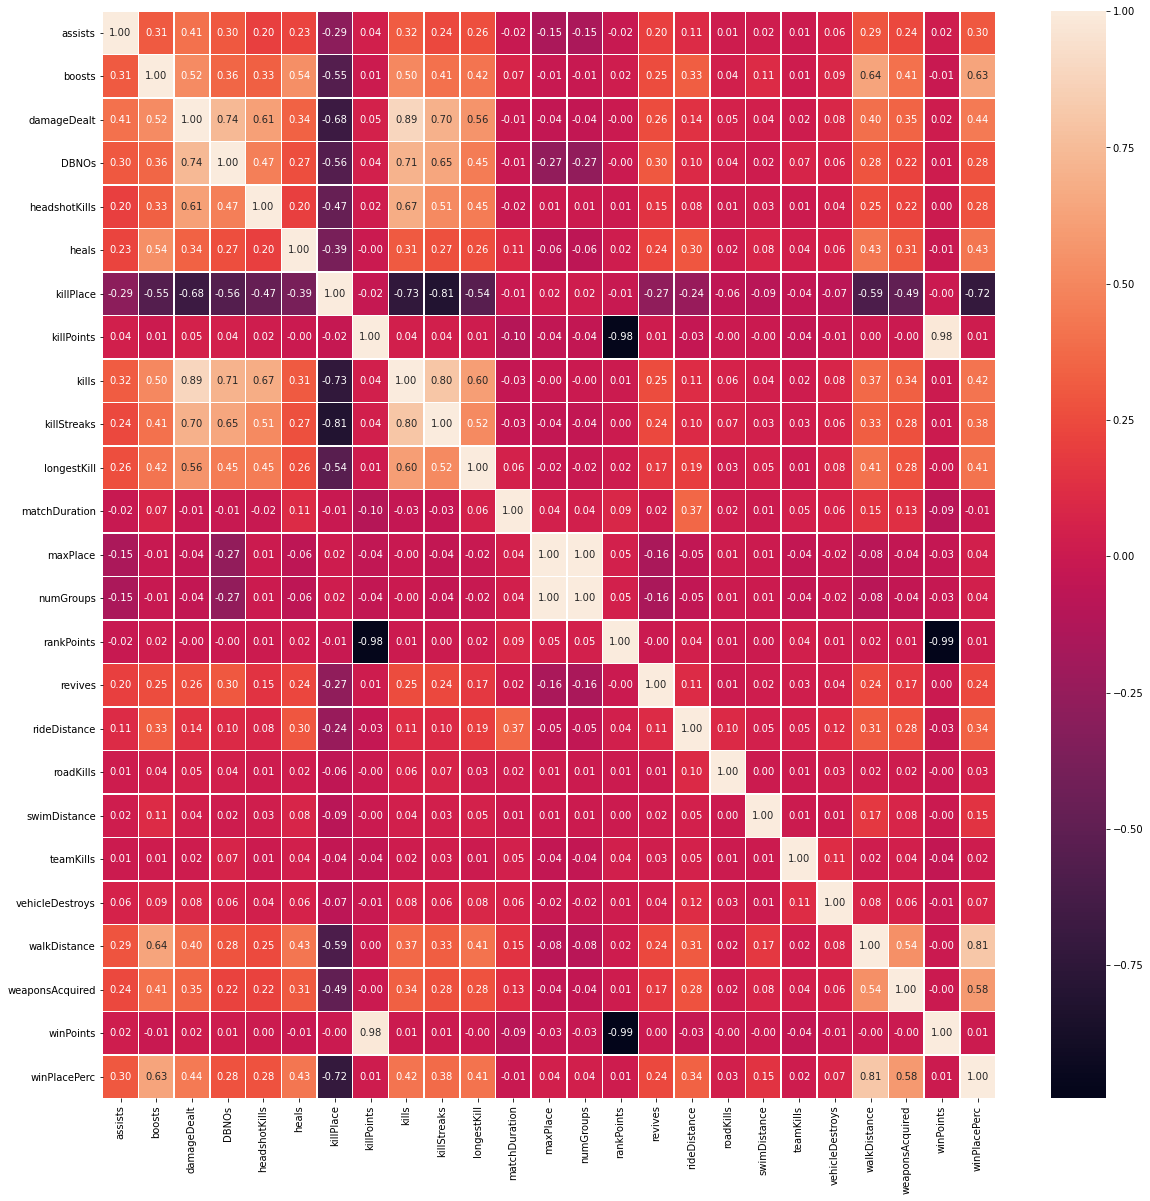

In [11]:
f,ax = plt.subplots(figsize=(20, 20))
sns.heatmap(df.corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax)
plt.show()

1. KillPoints & rankPoints & winPoints
2. numGroups & maxPlace
3. kills & damageDealt (corr = 0.89)

In [12]:
df = df.drop(['maxPlace', 'killPoints', 'rankPoints'], axis = 1)

### Categorical Variable coding

In [13]:
df = pd.get_dummies(df, columns=['matchType'])

### Outliers Remove(Cheaters)

1. Stand kill cheaters, which means no moving but kills player

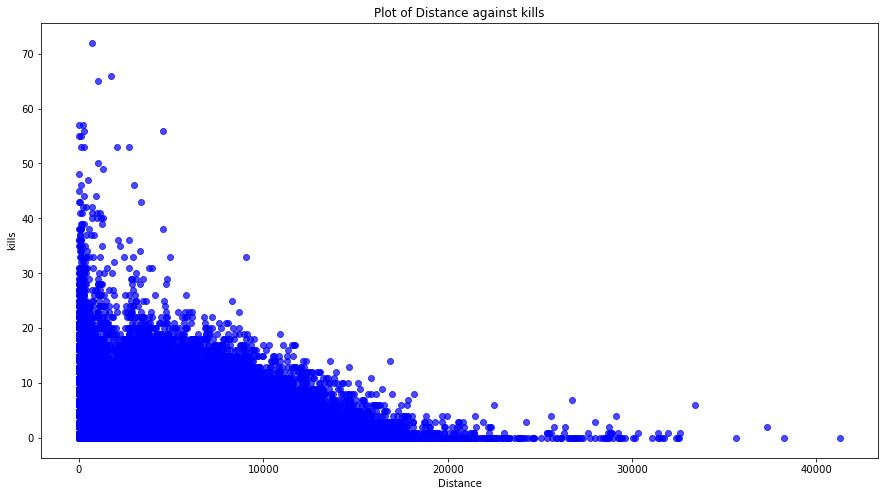

In [14]:
df['Distance'] = df['rideDistance'] + df['walkDistance'] + df['swimDistance']
plt.figure(figsize = (15 , 8))
plt.plot(df['Distance'], df['kills'], 'o', alpha = 0.7, color = 'b')
plt.xlabel('Distance')
plt.ylabel('kills')
plt.title('Plot of Distance against kills')
plt.show()

In [15]:
df['standkill_cheater']=((df['kills'] > 0) & (df['Distance'] == 0))
cheaters_data=df[df['standkill_cheater']==True]

In [16]:
df = df.drop(['rideDistance', 'walkDistance', 'swimDistance'], axis = 1)
#This three should be drop due to corelated with created column: Distance

In [17]:
cheaters_data.shape

(1535, 40)

2. longkill cheaters: The killing distance is too long

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


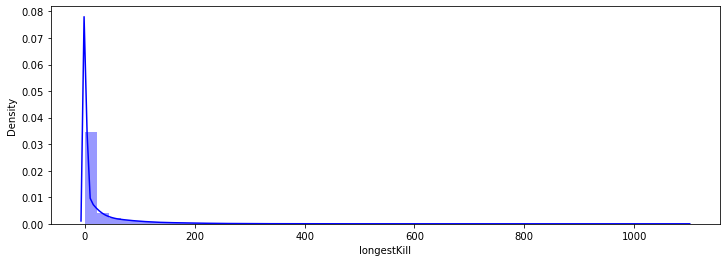

In [18]:
plt.figure(figsize=(12,4))
sns.distplot(df['longestKill'], kde = True, color = 'b')
plt.show()

In [19]:
df['longkill_cheater']=((df['longestKill'] >= 1000))
cheaters_data=pd.concat([cheaters_data,df[df['longkill_cheater']==True]])

In [20]:
cheaters_data.shape

(1558, 41)

3. Teleport cheater: who falsh travel and kills many players (not back stabber)

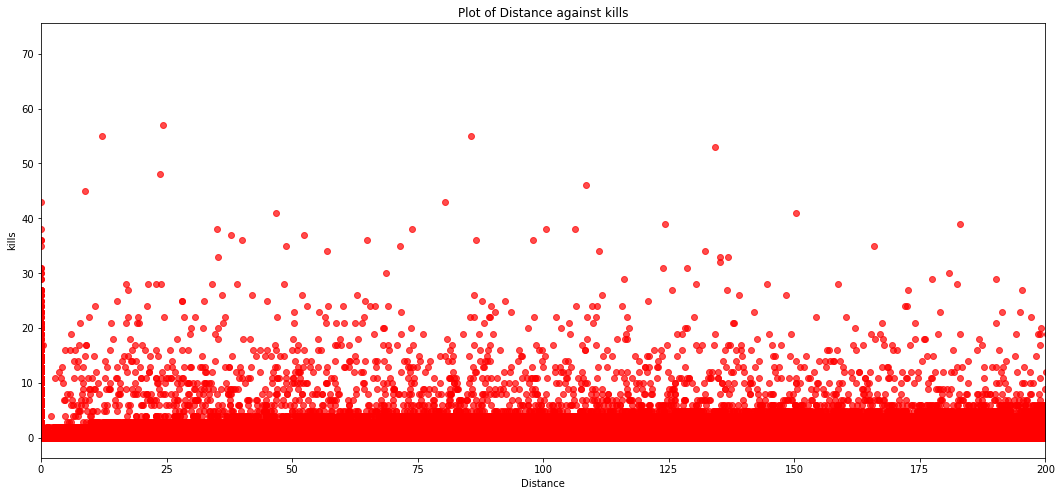

In [21]:
plt.figure(figsize = (18 , 8))
plt.plot(df['Distance'], df['kills'], 'o', alpha = 0.7, color = 'r')
plt.xlabel('Distance')
plt.ylabel('kills')
plt.title('Plot of Distance against kills')
plt.xlim(0, 200)
plt.show()

In [22]:
df['teleport_cheater'] = ((df['Distance'] < 200) & (df['kills'] > 20))
cheaters_data=pd.concat([cheaters_data,df[df['teleport_cheater']==True]])

In [23]:
cheaters_data.shape

(1743, 42)

4. Headshot cheaters: only made headshot with kill over 10

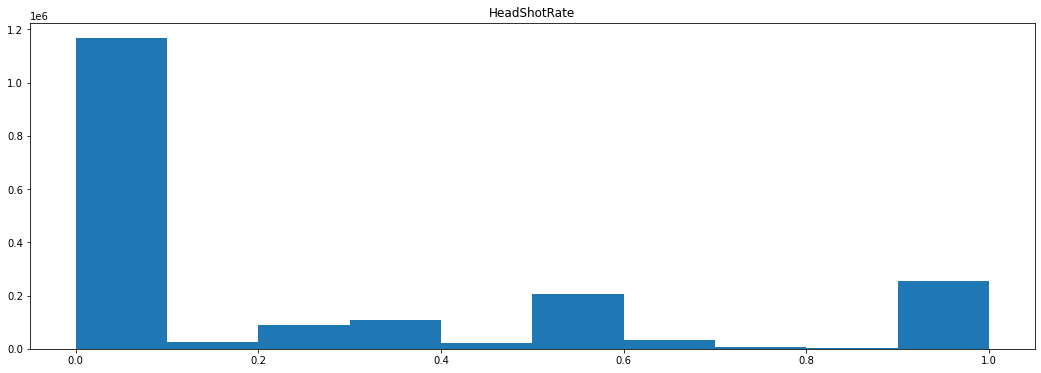

In [24]:
df['headkill_rate'] = df['headshotKills'] / df['kills']
plt.figure(figsize=(18,6))
plt.hist(df['headkill_rate'], bins = 10)
plt.title('HeadShotRate')
plt.show()

In [25]:
df['headkill_cheater'] = ((df['headkill_rate'] > 0.99) & df['kills'] >= 10)
cheaters_data=pd.concat([cheaters_data,df[df['headkill_cheater']==True]])

In [26]:
df.drop('headkill_rate', axis = 1, inplace = True)

In [27]:
cheaters_data.shape

(1743, 44)

5. Over record cheaters: Kill over the world record of kills in a match

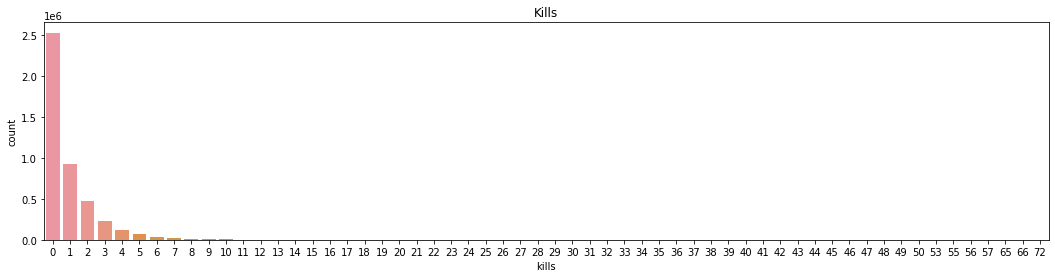

In [28]:
plt.figure(figsize=(18,4))
sns.countplot(data=df, x=df['kills']).set_title('Kills')
plt.show()

In [29]:
df['overkill_cheater'] = df['kills'] > 59
cheaters_data=pd.concat([cheaters_data,df[df['overkill_cheater']==True]])

In [30]:
cheaters_data.shape

(1746, 45)

6. see how many cheaters do we detected

In [31]:
cheaters_data.shape

(1746, 45)

7. drop it

In [32]:
df.drop(df[df['standkill_cheater']==True].index,inplace=True)
df.drop(df[df['longkill_cheater']==True].index,inplace=True)
df.drop(df[df['teleport_cheater']==True].index,inplace=True)
df.drop(df[df['headkill_cheater']==True].index,inplace=True)
df.drop(df[df['overkill_cheater']==True].index,inplace=True)

In [33]:
df.drop('standkill_cheater',axis = 1, inplace=True)
df.drop('longkill_cheater',axis = 1, inplace=True)
df.drop('teleport_cheater',axis = 1, inplace=True)
df.drop('headkill_cheater',axis = 1, inplace=True)
df.drop('overkill_cheater',axis = 1, inplace=True)

In [34]:
target = df['winPlacePerc']
df = df.drop('winPlacePerc', axis = 1)

In [35]:
df.shape

(4445268, 35)

### Random Forest implementation

In [36]:
X_train,X_test,y_train,y_test = train_test_split(df,target,test_size=0.2,random_state=0)

In [37]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [38]:
#Not a big diff between the sqrt or log2 max_features arguments
import math
print(math.log2(35), np.sqrt(35))

5.129283016944966 5.916079783099616


In [39]:
import time
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 400.1986298561096 seconds


In [40]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.04860561386623228
Training MSE: 0.00452442638309703
Training RMSE: 0.06726385643937634
Training R-squared: 0.9521024961516593
-------------------------------------
Testing MAE: 0.06341251351871381
Testing MSE: 0.007751513574592173
Testing RMSE: 0.08804268041462716
Testing R-squared: 0.9180440369965363


In [41]:
rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=3, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 313.3821051120758 seconds


In [42]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.048745799777703734
Training MSE: 0.004554314831137199
Training RMSE: 0.06748566389343147
Training R-squared: 0.9517860843164766
-------------------------------------
Testing MAE: 0.06366612090539152
Testing MSE: 0.007827448569148117
Testing RMSE: 0.08847286911335088
Testing R-squared: 0.917241184038258


In [43]:
rf = RandomForestRegressor(n_estimators=20, min_samples_leaf=3, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 200.09446597099304 seconds


In [44]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.04917833834867139
Training MSE: 0.0046459719566303865
Training RMSE: 0.0681613670390375
Training R-squared: 0.9508157629653681
-------------------------------------
Testing MAE: 0.06404242589407584
Testing MSE: 0.007914549690790721
Testing RMSE: 0.08896375492744628
Testing R-squared: 0.9163202727563247


In [45]:
rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=4, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 294.8687720298767 seconds


In [46]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.05259039120738902
Training MSE: 0.005275369198680565
Training RMSE: 0.07263173685573383
Training R-squared: 0.9441526958115165
-------------------------------------
Testing MAE: 0.06403710663083839
Testing MSE: 0.007886361394124032
Testing RMSE: 0.0888051878784344
Testing R-squared: 0.9166183047440797


In [47]:
rf = RandomForestRegressor(n_estimators=30, min_samples_leaf=2, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 325.25870013237 seconds


In [48]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.04170270778476872
Training MSE: 0.003374263146900934
Training RMSE: 0.05808840802518979
Training R-squared: 0.9642786138221192
-------------------------------------
Testing MAE: 0.06311319390420266
Testing MSE: 0.007726657942300395
Testing RMSE: 0.08790141035444422
Testing R-squared: 0.9183068330635147


In [49]:
rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=2, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 428.6736238002777 seconds


In [50]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.041532725325963735
Training MSE: 0.0033436493826203314
Training RMSE: 0.057824297510824386
Training R-squared: 0.9646027041638077
-------------------------------------
Testing MAE: 0.0629143908541391
Testing MSE: 0.007684386140550619
Testing RMSE: 0.08766063050509401
Testing R-squared: 0.918753768515147


In [51]:
rf = RandomForestRegressor(n_estimators=50, min_samples_leaf=2, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 466.7321720123291 seconds


In [52]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.0412888137870424
Training MSE: 0.003292138633683736
Training RMSE: 0.05737716125501275
Training R-squared: 0.9651480188814123
-------------------------------------
Testing MAE: 0.06265742278656286
Testing MSE: 0.007599223793969285
Testing RMSE: 0.08717352691023396
Testing R-squared: 0.9196541813259541


In [53]:
rf = RandomForestRegressor(n_estimators=60, min_samples_leaf=2, max_features = 'sqrt')

start_t = time.time()
rf.fit(X_train, y_train)
end_t = time.time()

y_train_pred = rf.predict(X_train)
y_test_pred = rf.predict(X_test)
print("Training time:", end_t - start_t, "seconds")

Training time: 575.8927960395813 seconds


In [54]:
train_mae = mean_absolute_error(y_train, y_train_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
test_r2 = r2_score(y_test, y_test_pred)

print("Training MAE:", train_mae)
print("Training MSE:", train_mse)
print("Training RMSE:", np.sqrt(train_mse))
print("Training R-squared:", train_r2)
print('-------------------------------------')
print("Testing MAE:", test_mae)
print("Testing MSE:", test_mse)
print("Testing RMSE:", np.sqrt(test_mse))
print("Testing R-squared:", test_r2)

Training MAE: 0.041237067486348616
Training MSE: 0.003281286680715949
Training RMSE: 0.057282516361591075
Training R-squared: 0.9652629022754661
-------------------------------------
Testing MAE: 0.0625287688719854
Testing MSE: 0.007558527664143515
Testing RMSE: 0.08693979332931218
Testing R-squared: 0.9200844573589236


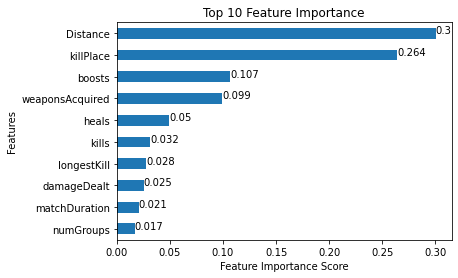

In [55]:
feat_importances = pd.Series(rf.feature_importances_, index=df.columns)
feat_importances.nlargest(10).sort_values().plot(kind='barh')
for index, value in enumerate(feat_importances.nlargest(10).sort_values()):
    plt.text(value, index, str(round(value,3)))
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Top 10 Feature Importance")
plt.show()